# Template SCENIC Preprocessing Notebook

**Authorship:**
Adam Klie, *02/17/2022*
***
**Description:**
Template notebook for preprocessing single cell data for running the SCENICprotocol and for general and SCENIC analysis
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

# Set-up

In [1]:
# The classics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#np.random.seed(13)

# Single cell
import scanpy as sc
sc.logging.print_header()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
sc.settings.njobs = 16
sc.settings.verbosity = 3 

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

scanpy==1.7.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [2]:
# File paths
f_loom_path_scenic = "data/pbmc10k_filtered_scenic.loom"  # loom file with basic filtering applied
f_anndata_path = "data/pbmc10k_anndata.h5ad"  # # path to anndata object, which will be updated to store Scanpy results as they are generated below

# Load data

In [26]:
# Update this with path to 10x data or other path
adata = sc.read_10x_mtx("/cellar/users/aklie/data/single_cell/gex/pbmc_10k_v3/filtered_feature_bc_matrix/",  var_names='gene_symbols', cache=True)

... reading from cache file cache/cellar-users-aklie-data-single_cell-gex-pbmc_10k_v3-filtered_feature_bc_matrix-matrix.h5ad


# Summarize the data

In [27]:
# Simple info
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)

# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')

# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


... storing 'feature_types' as categorical


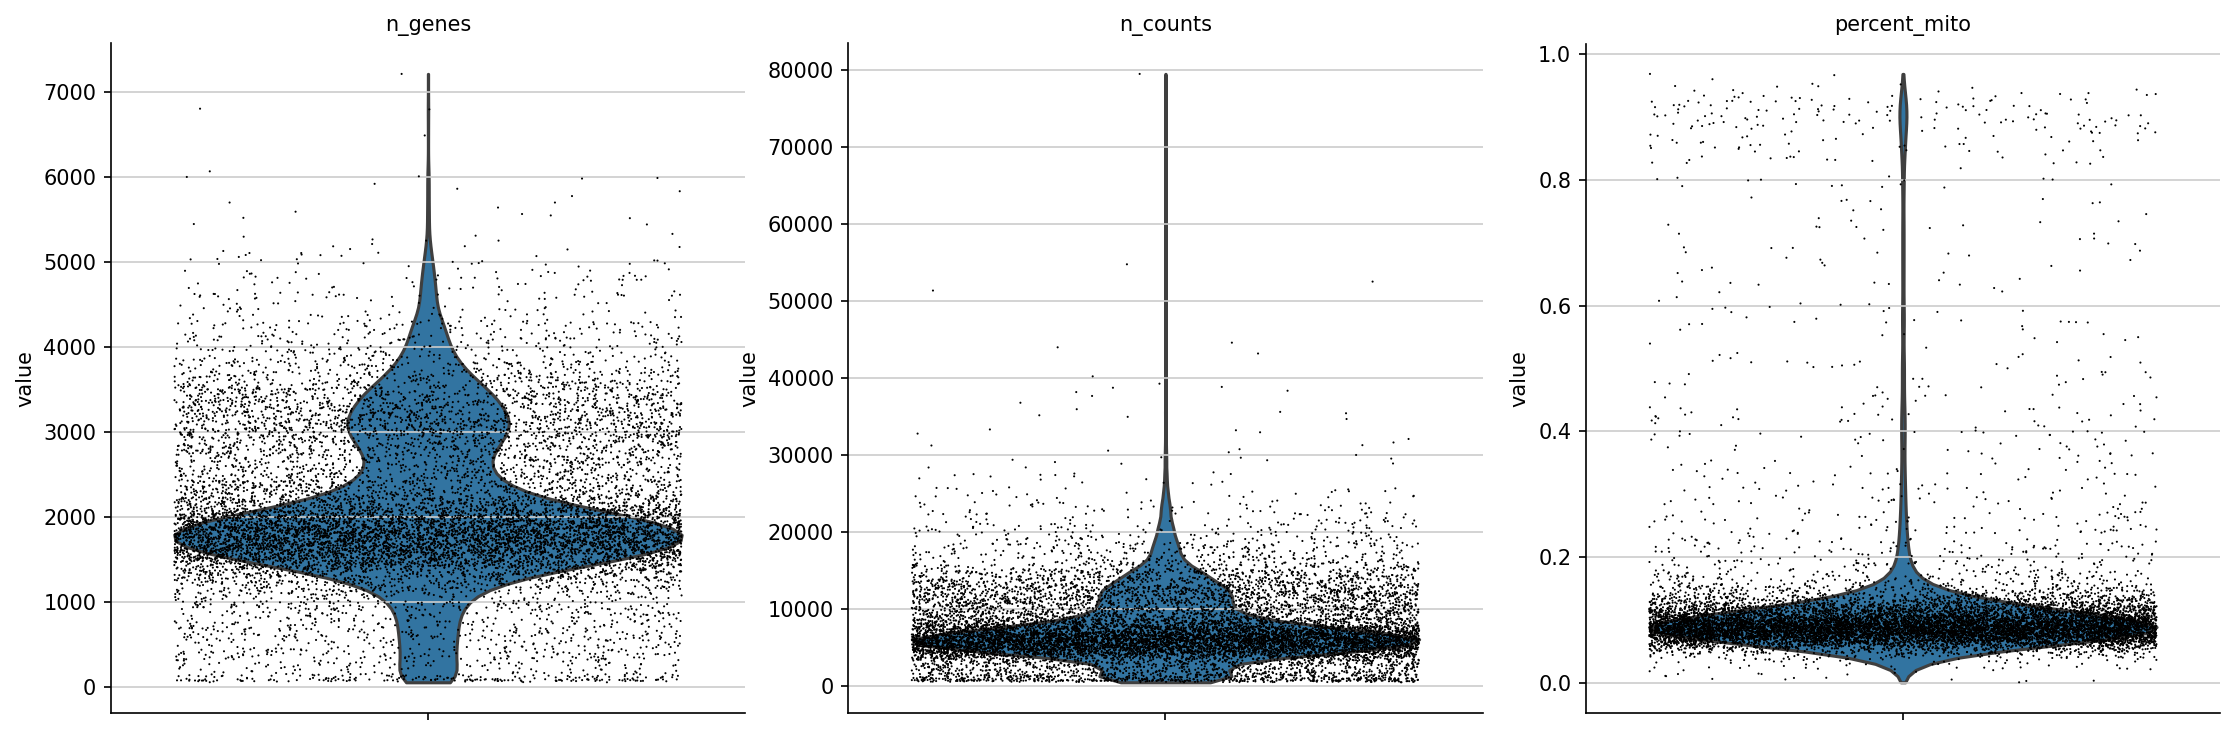

In [28]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True )

# Filter the data

In [29]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

# harder cuts
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


In [30]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

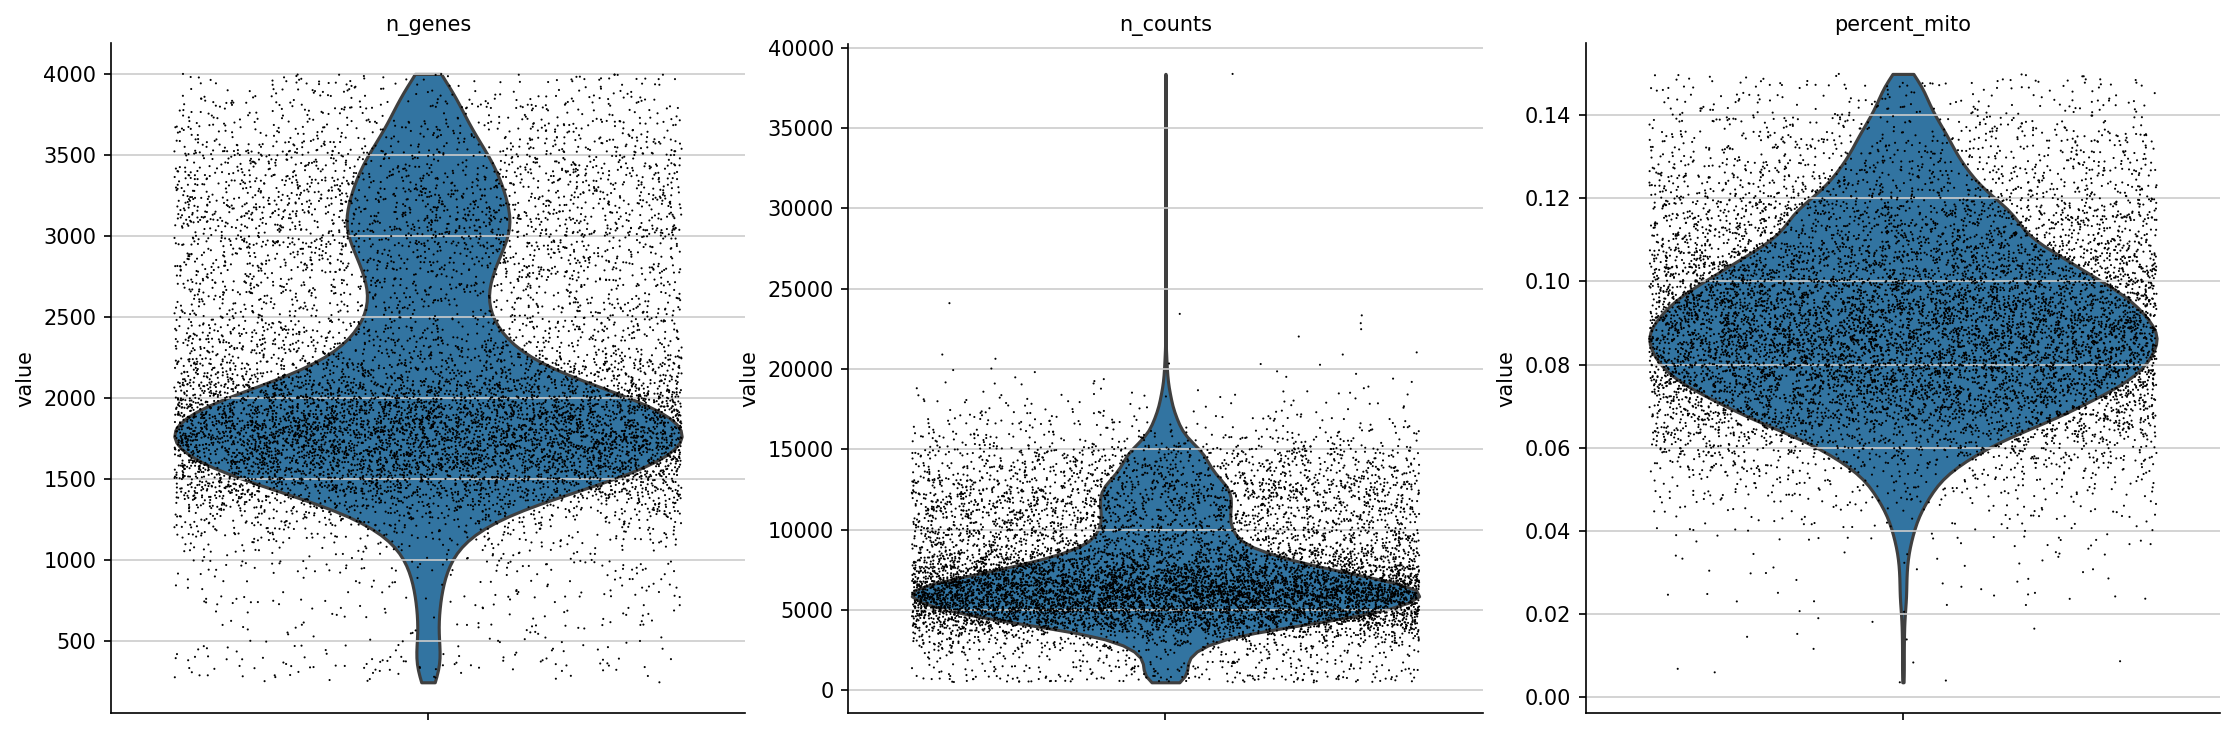

In [31]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True )

In [32]:
import loompy as lp

In [33]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create(f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [34]:
adata.write(f_anndata_path)

# Scanpy analysis

## Scale factor, log an regression normalization
Includes subset to variable genes after scale factor and log norm

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


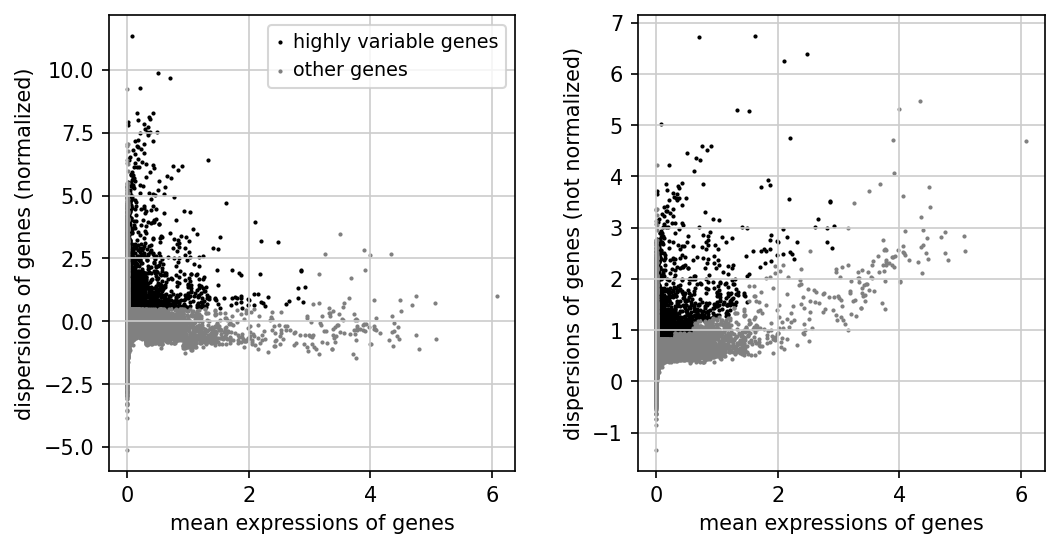

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [35]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

## Dim reduction via PCA, t-SNE and UMAP

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


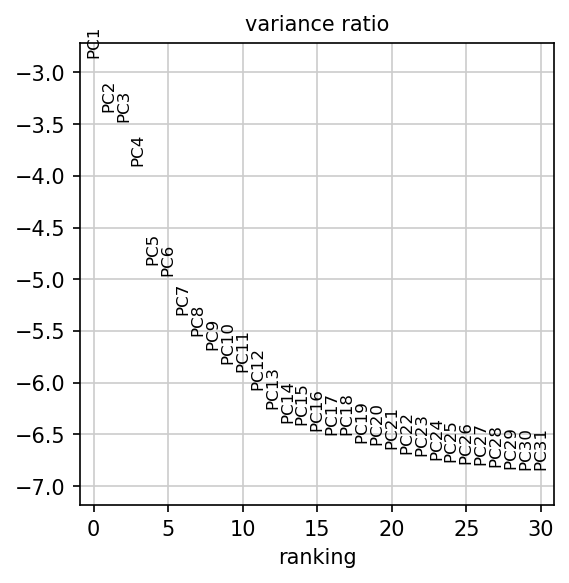

In [36]:
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [37]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [38]:
# t-SNE
tsne = TSNE(n_jobs=16)
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )

In [39]:
# neighborhood graph of cells (determine optimal number of PCs here) and UMAP
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


## Clustering and visualization

In [40]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


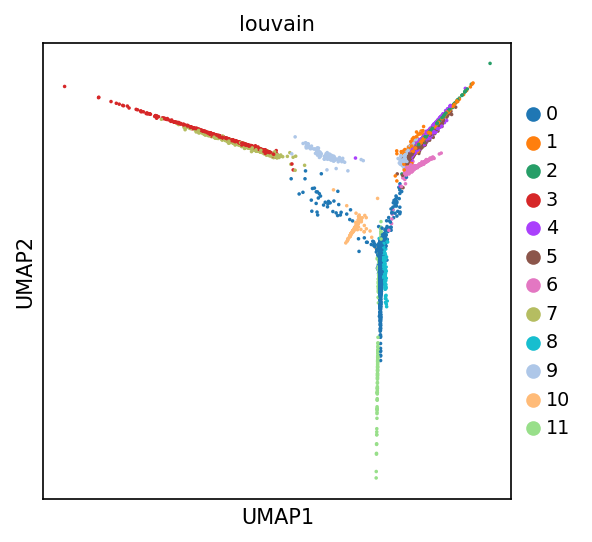

In [41]:
# Viz
sc.pl.umap(adata, color=['louvain'] )

## ID Marker Genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


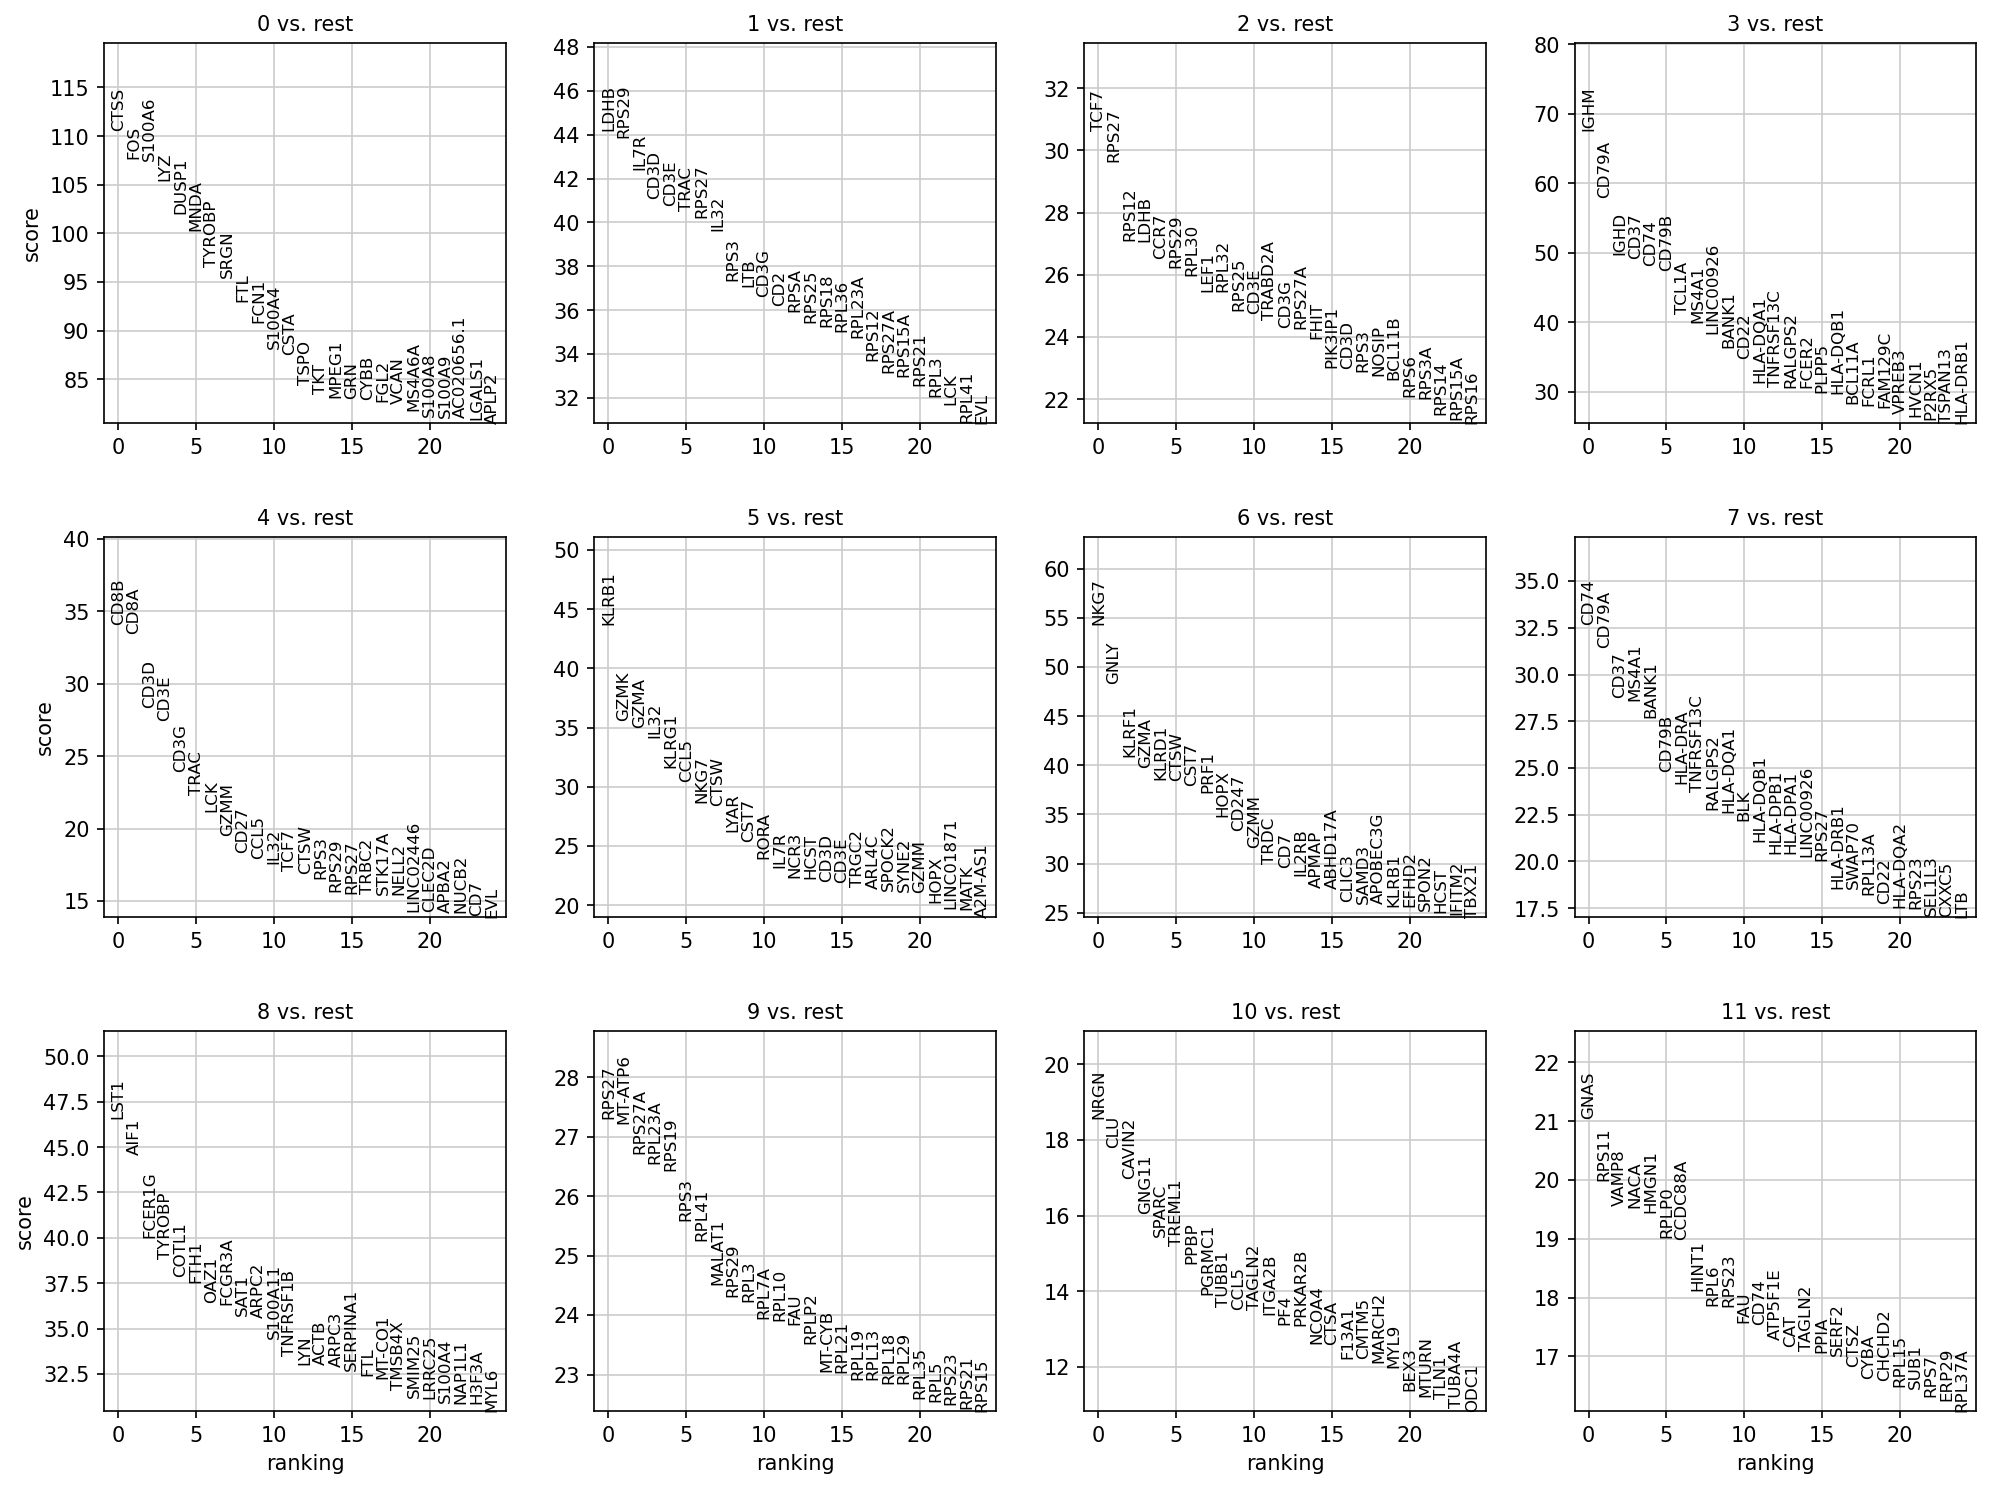

,0,1,2,3,4,5,6,7,8,9,10,11
0,CTSS,LDHB,TCF7,IGHM,CD8B,KLRB1,NKG7,CD74,LST1,RPS27,NRGN,GNAS
1,FOS,RPS29,RPS27,CD79A,CD8A,GZMK,GNLY,CD79A,AIF1,MT-ATP6,CLU,RPS11
2,S100A6,IL7R,RPS12,IGHD,CD3D,GZMA,KLRF1,CD37,FCER1G,RPS27A,CAVIN2,VAMP8
3,LYZ,CD3D,LDHB,CD37,CD3E,IL32,GZMA,MS4A1,TYROBP,RPL23A,GNG11,NACA
4,DUSP1,CD3E,CCR7,CD74,CD3G,KLRG1,KLRD1,BANK1,COTL1,RPS19,SPARC,HMGN1
5,MNDA,TRAC,RPS29,CD79B,TRAC,CCL5,CTSW,CD79B,FTH1,RPS3,TREML1,RPLP0
6,TYROBP,RPS27,RPL30,TCL1A,LCK,NKG7,CST7,HLA-DRA,OAZ1,RPL41,PPBP,CCDC88A
7,SRGN,IL32,LEF1,MS4A1,GZMM,CTSW,PRF1,TNFRSF13C,FCGR3A,MALAT1,PGRMC1,HINT1
8,FTL,RPS3,RPL32,LINC00926,CD27,LYAR,HOPX,RALGPS2,SAT1,RPS29,TUBB1,RPL6
9,FCN1,LTB,RPS25,BANK1,CCL5,CST7,CD247,HLA-DQA1,ARPC2,RPL3,CCL5,RPS23


In [42]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# Show the top 10 for each cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

In [43]:
adata.write(f_anndata_path)

# AUC Threshold Check

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = pd.Series(nGenesDetectedPerCell).quantile([.01, .05, .10, .50, 1])
print(percentiles)
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

<div class="alert alert-success" role="alert">
  <h4 class="alert-heading">Well done!</h4>
  <p>You successfully preprocessed your data
  <hr>
  <p class="mb-0">Onto running the <b>SCENICprotocol</b>!</p>
</div>

# References